# Ryzen AI 推論デモ

1. 量子化済みのモデルを使って XDNA NPU で推論を実行します
2. AI Analyzer で実行時のタイムラインを表示します

### 1.1 画像の読み込み

- あらかじめ 640x640 にリサイズした画像を OpenCV を使って読み込みます。
- ONNX Runtime への入力に合わせるために、
  - ピクセルの並びを RGB へ変更します。
  - 0 ~ 1 の範囲に値をスケールします。
  - バッチ入力の形状にデータを変形します。

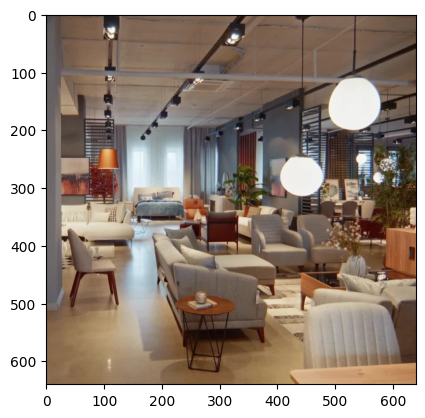

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 画像ファイルを読み込み
img_org = cv2.imread("sample/furniture_store.jpg")
# BGR から RGB へ変換
img_rgb = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
# 画素の値を 0 ~ 1 に変換
img = np.divide(img_rgb, 255, dtype=np.float32)
# 形状をバッチに変換 (3, 640, 640) -> (1, 3, 640, 640)
img = np.reshape(img, (1, *img.shape))

plt.imshow(img[0])

### 1.2 ONNX Runtime Inference Session の作成

- NPU を使用して ONNX モデルの推論を実行するためのセッションを作成します。
- ONNX モデルを NPU で処理するためのコンパイルが実行されます（2回目以降はキャッシュを利用します）。

In [10]:
import os
import shutil
import onnxruntime

enable_analyzer = False
cache_dir = os.path.join(os.getcwd(),  r'cache')
#shutil.rmtree(cache_dir, ignore_errors=True)

session = onnxruntime.InferenceSession(
    # 量子化済み ONNX モデルを指定
    "lib/yolov8m.onnx",
    # NPU を使用して推論を実行するように指示
    providers = ['VitisAIExecutionProvider'],
    # NPU 実行に関するオプション
    provider_options = [{
        'config_file': f"{os.environ['VAIP_CONFIG_HOME']}/vaip_config.json",
        'num_of_dpu_runners': 4,
        'cacheDir': cache_dir,
        'cacheKey': 'yolov8m',
        'ai_analyzer_visualization': enable_analyzer,
        'ai_analyzer_profiling': enable_analyzer,
    }]
)

### 1.3 推論の実行

- 用意した画像データを入力として推論を実行します。

In [12]:
outputs = session.run(None, { session.get_inputs()[0].name: img })

- 推論を20回実行したときの時間を計測します。

In [23]:
%%timeit -r 1 -n 1
for _ in range(20):
    session.run(None, { session.get_inputs()[0].name: img })

2.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- スレッドにより推論を並列実行したときの時間を計測します。

In [26]:
%%timeit -r 1 -n 1
import threading

def infer():
    session.run(None, { session.get_inputs()[0].name: img })

threads = [threading.Thread(target=infer) for _ in range(20)]

for thr in threads: thr.start()
for thr in threads: thr.join()

573 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


NPU 内に4つのAI演算コアが実装されており、すべてのコアを並列で動作させることで最大のスループットを得られます。

<img src="sample/ryzen-ai-npu.png" width="40%">

### 1.4 推論結果の確認

- NPU の出力に対する後処理を CPU で実行します。
- 推論した結果を画像に描画します。

In [27]:
import torch
from lib.yolov8 import (
    post_process,
    non_max_suppression,
    output_to_target,
    load_coco_names,
    Annotator,
    colors,
)

# Post processing
preds = post_process([torch.tensor(item).permute(0, 3, 1, 2) for item in outputs])
preds = non_max_suppression(
    preds, conf_thres=0.25, iou_thres=0.45, agnostic=False, max_det=300, classes=None
)
preds = output_to_target(preds, max_det=300)

# Draw detection result
scale = 2
img_out = cv2.resize(img_org, (640 * scale, 640 * scale))
names = load_coco_names()
annotator = Annotator(img_out, line_width=3)
for i, (batch, cls, bbox) in enumerate(zip(*preds)):
    cls = int(cls)
    conf = int(bbox[4] * 100)

    label = f"{names[cls]} :{conf:3}%"

    xy = bbox[0:2] * scale
    wh = bbox[2:4] * scale
    xy -= wh // 2 # center to top-left
    xy2 = xy + wh

    annotator.box_label([*xy, *xy2], label, colors(cls))

cv2.imwrite("output.jpg", img_out)

c:\Users\juna\AppData\Local\miniconda3\envs\ryzen-ai-1.3.1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load anchors.npy
Load strides.npy


True

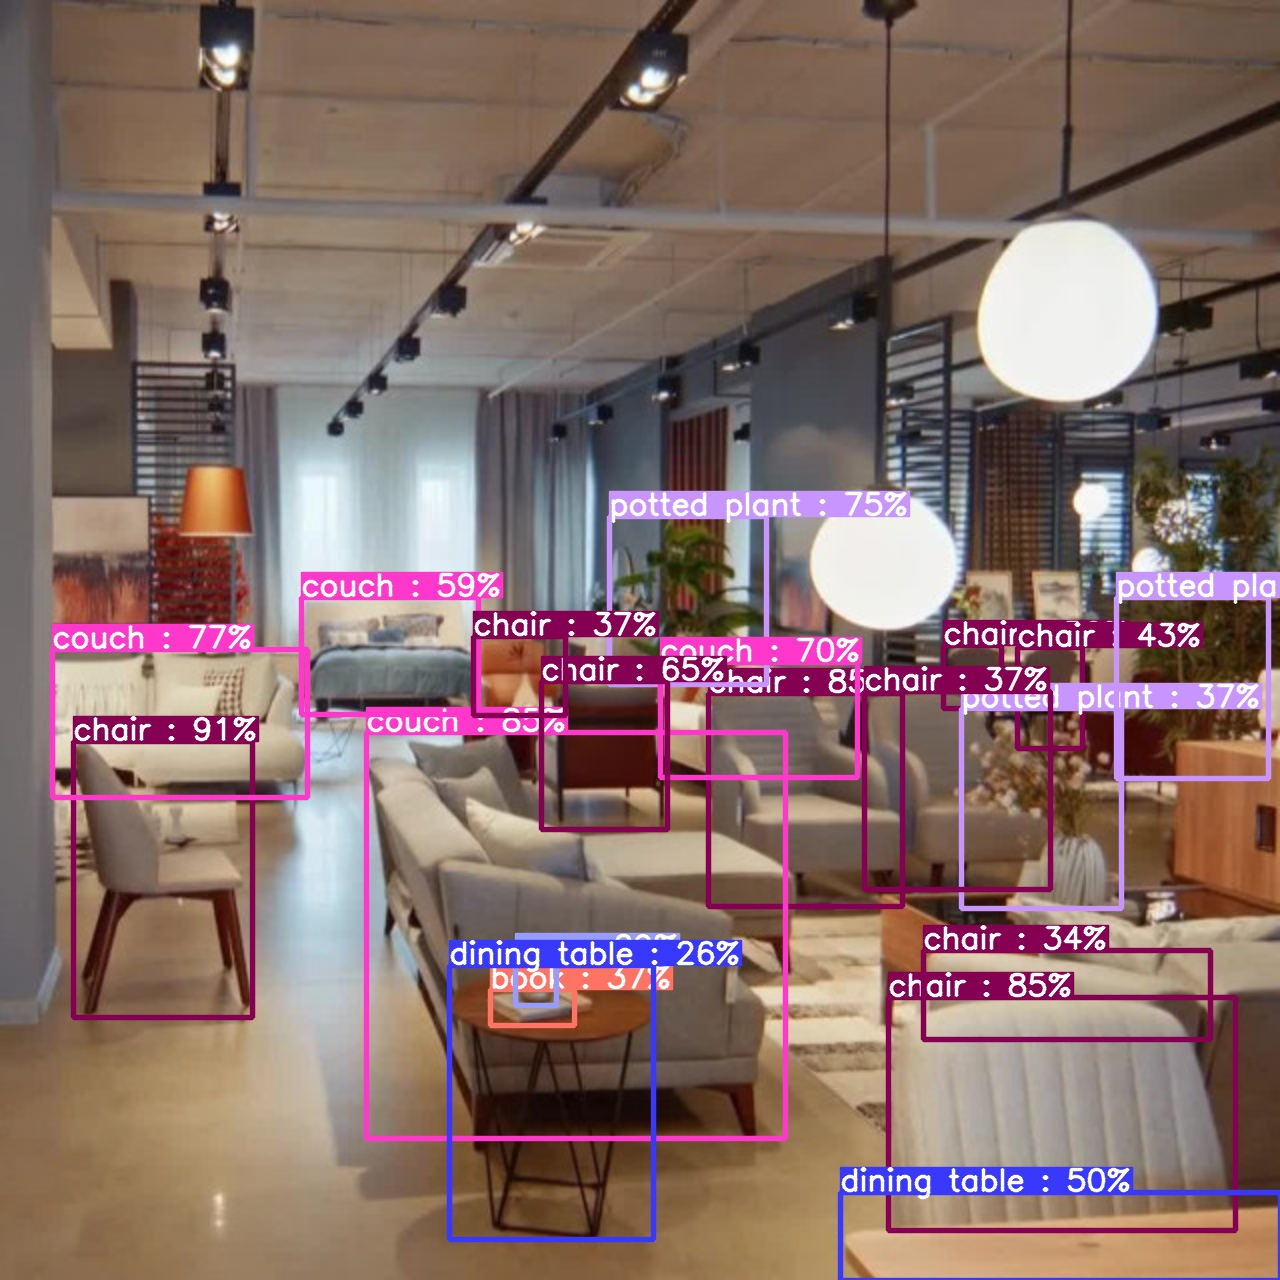

In [28]:
from IPython.display import Image
Image(filename='output.jpg', width="60%")

### 2. AI Analyzer によるタイムラインの確認

- あらかじめ取得したプロファイルをサンプルとして使用します。

In [ ]:
!aianalyzer sample/analyzer -p 8001

- 詳細なタイムラインからパフォーマンスの解析を行うことができます。

![analyzer](sample/analyzer.png)